In [35]:
%run ../../../utils/commonImports.py
%run ../../../utils/tradingImports.py
%matplotlib inline

from base import supres
from exputils import *

# Load data

In [36]:
dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
# dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'
features = ['change_1']
pairs = read_tsv('selected-pairs.tsv', header=None)[0].tolist()

# data_dict = {p: read_all(p, dropbox_dir) for p in pairs}
train = read_tsv('train.tsv')
validation = read_tsv('validation.tsv')

In [37]:
train.head()

,index,support,pair,win_size,date,max_profit,change_1,change_2,change_3,max_profit_consolidated
0,24.0000,0.0021,BTC_ETH,4,2016-01-01 12:00:00,0.0261,0.0000,0.0000,0.0000,0.0000
1,33.0000,0.0022,BTC_ETH,4,2016-01-01 16:30:00,-0.0040,0.0089,0.0000,0.0000,-0.0040
2,45.0000,0.0022,BTC_ETH,4,2016-01-01 22:30:00,0.0274,-0.0015,0.0074,0.0000,0.0013
3,58.0000,0.0022,BTC_ETH,4,2016-01-02 05:00:00,0.0079,0.0234,0.0218,0.0309,0.0199
4,70.0000,0.0022,BTC_ETH,4,2016-01-02 11:00:00,0.0020,0.0034,0.0269,0.0253,0.0029


In [38]:
validation.head()

,index,support,pair,win_size,date,max_profit,change_1,change_2,change_3,max_profit_consolidated
0,"17,580.0000",0.0086,BTC_ETH,4,2017-01-01 06:00:00,-0.0050,0.0432,0.0444,0.0367,-0.0050
1,"17,589.0000",0.0084,BTC_ETH,4,2017-01-01 10:30:00,0.0055,-0.0279,0.0141,0.0152,0.0055
2,"17,598.0000",0.0085,BTC_ETH,4,2017-01-01 15:00:00,-0.0019,0.0077,-0.0204,0.0219,-0.0019
3,"17,603.0000",0.0083,BTC_ETH,4,2017-01-01 17:30:00,0.0011,-0.0189,-0.0113,-0.0389,0.0011
4,"17,610.0000",0.0081,BTC_ETH,4,2017-01-01 21:00:00,0.0095,-0.0283,-0.0466,-0.0393,0.0095


# Train validation split

In [45]:
from sklearn.model_selection import train_test_split

train_data = train.query('change_1 < 0').copy()

X_train = train_data[features].values
y_train = train_data['max_profit_consolidated'].values

X_val = validation[features].values
y_val = validation['max_profit_consolidated'].values

# Threshold on change

In [74]:
data = train_data.copy()
data['satisfied'] = data['max_profit'] >= (-data['change_1'] * 0.3)

def win_ratio(threshold):
    tmp_data = data.query(f'change_1 < {threshold}').copy()
    grouped = tmp_data[['satisfied', 'max_profit']].groupby('satisfied').count()
    ratio = grouped['max_profit'][True] / grouped['max_profit'].sum()
    return ratio

thresholds = [-i/100 for i in range(20)]
plot_data = np.array([[thrs, win_ratio(thrs)] for thrs in thresholds])

# Report

In [46]:
from sklearn.metrics import mean_squared_error

def plt_reg(x, y, ax, title, xlabel, ylabel):
    sns.regplot(x, y, ax=ax)
    ax.set_title(title, fontproperties=title_font)
    ax.set_xlabel(xlabel, fontproperties=axis_font)
    ax.set_ylabel(ylabel, fontproperties=axis_font)

def reg_report(X, y_true, reg):
    y_pred = reg.predict(X)
    ms_err = mean_squared_error(y_true, y_pred)
    print('Mean squared error', ms_err)
    
    _, axes = plt.subplots(1, 2, figsize=[13, 5])
    plt_reg(X[:, 0], y_true, axes[0], 'True', 'change_1', 'y_true')
    plt_reg(X[:, 0], y_pred, axes[1], 'Predicted', 'change_1', 'y_pred')
    
    plt.figure(figsize=[12, 6])
    sns.regplot(y_true, y_pred)
    plt.xlabel('y_true', fontproperties=axis_font)
    plt.ylabel('y_pred', fontproperties=axis_font)
    plt.title('True - Pred comparison', fontproperties=title_font)

# Linear regression

In [47]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=True, normalize=True)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [53]:
tmp['satisfied'] = tmp['max_profit'] >= -tmp['change_1']

In [55]:
tmp.groupby('satisfied').count()

,index,support,pair,win_size,date,max_profit,change_1,change_2,change_3,max_profit_consolidated,predicted
satisfied,,,,,,,,,,,
False,8101,8101,8101,8101,8101,8101,8101,8101,8101,8101,8101
True,7687,7687,7687,7687,7687,7687,7687,7687,7687,7687,7687


In [49]:
tmp = train_data.copy()
tmp['predicted'] = reg.predict(X_train)

In [50]:
tmp[['change_1', 'max_profit', 'max_profit_consolidated', 'predicted']]\
    .query('max_profit > 0')\
    .query('max_profit < 0.02')

,change_1,max_profit,max_profit_consolidated,predicted
5,-0.0173,0.0071,0.0071,0.0081
6,-0.0085,0.0035,0.0035,0.0041
12,-0.0117,0.0078,0.0078,0.0056
13,-0.0035,0.0125,0.0030,0.0018
14,-0.0096,0.0061,0.0061,0.0046
15,-0.0204,0.0056,0.0056,0.0095
19,-0.0010,0.0043,0.0009,0.0007
22,-0.0020,0.0131,0.0017,0.0011
23,-0.0024,0.0014,0.0014,0.0013
24,-0.0048,0.0038,0.0038,0.0024


### Train set report

Mean squared error 0.00012097753402097469


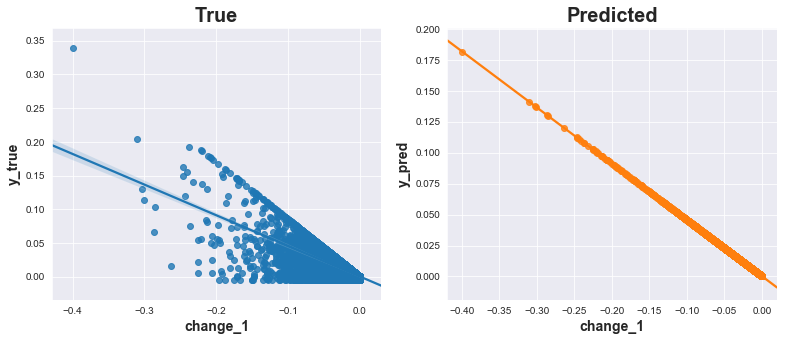

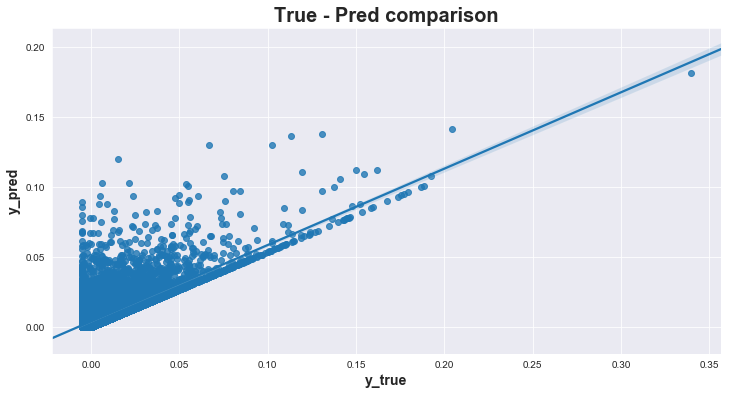

In [51]:
y_true = y_train
reg_report(X_train, y_true, reg)

### Validation set report

Mean squared error 0.00012599911476833122


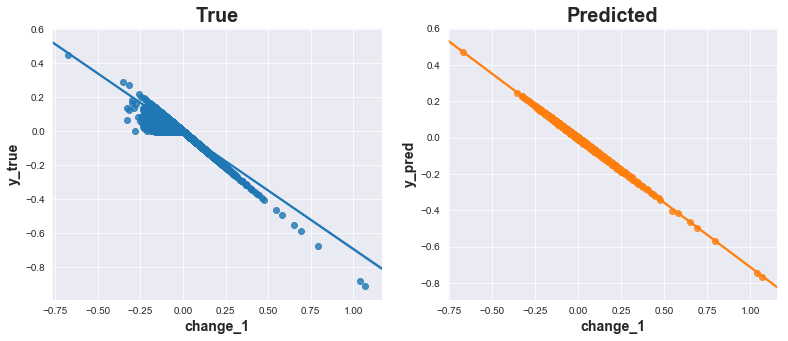

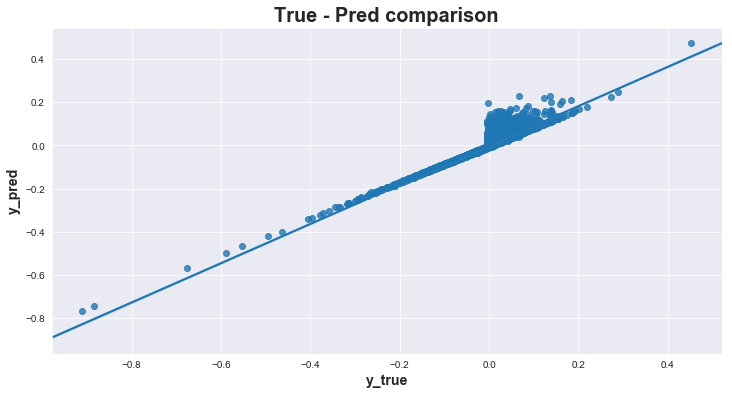

In [9]:
y_true = y_val
reg_report(X_val, y_true, reg)

# Save Regression

In [10]:
from sklearn.linear_model import LinearRegression
save_model(reg, 'models/lin_regression.pkl')